<a href="https://colab.research.google.com/github/SatrioHSamudra/Predator-Acoustic-Soundscape/blob/main/Sonograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


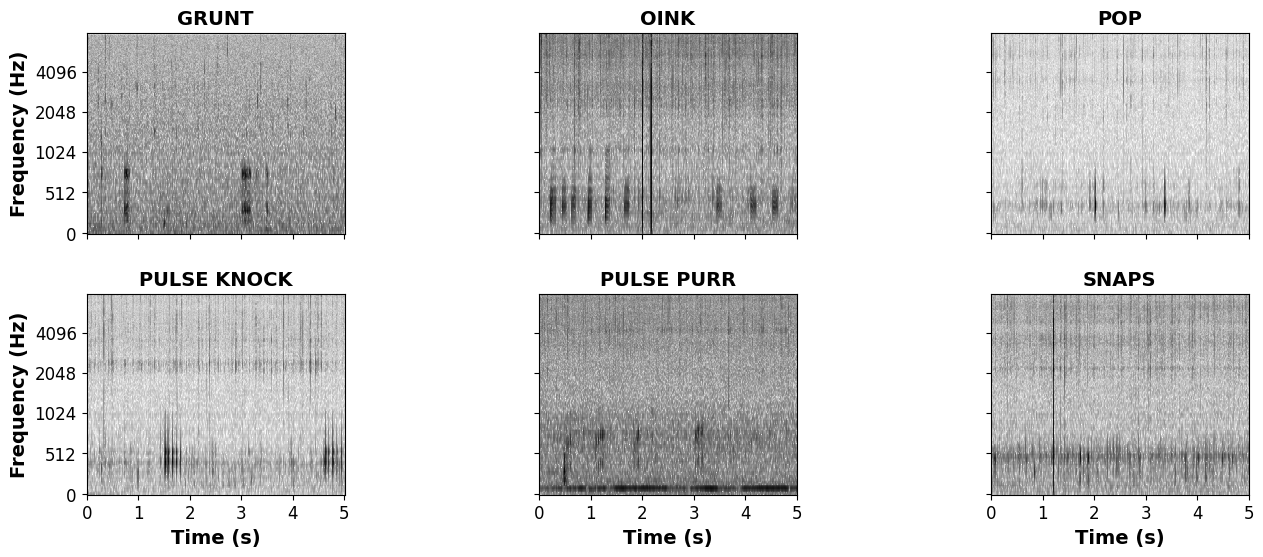

In [6]:
import os
import random
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from typing import List, Dict

# Set spectrogram size
SPEC_WIDTH = 5
SPEC_HEIGHT = 3
SPEC_HGAP = 0.75
SPEC_VGAP = 0.3

AUDIO_DIR = "/content/drive/MyDrive/UCL/MSc_Dissertation/Sonotypes"
OUTPUT_FILE = "/content/drive/MyDrive/UCL/MSc_Dissertation/Figures/sonograms.png"

# Helper function to call each sonotype

def get_random_file_per_sonotype(folder_path: str) -> Dict[str, str]:
    """
    Randomly select one .wav file from each subfolder (representing one sonotype).
    Returns a dictionary with {sonotype_name: file_path}.
    """
    sonotype_files = {}
    for sonotype in sorted(os.listdir(folder_path)):
        sonotype_dir = os.path.join(folder_path, sonotype)
        if os.path.isdir(sonotype_dir):
            wav_files = [f for f in os.listdir(sonotype_dir) if f.lower().endswith(".wav")]
            if wav_files:
                chosen = random.choice(wav_files)
                sonotype_files[sonotype] = os.path.join(sonotype_dir, chosen)
    return sonotype_files

def compute_log_mel_spectrogram(file_path: str, sr: int = 16000, duration: float = 5.0) -> np.ndarray:
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    if len(y) > sr * duration:
        y = y[: int(sr * duration)]
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=1024,
        win_length=512,
        hop_length=256,
        window="hann",
        pad_mode="constant",
        power=2.0,
        fmax=8000,
        n_mels=264,
    )
    return librosa.power_to_db(mel_spec, ref=np.max)

def plot_spectrogram_grid(
    spectrograms: List[np.ndarray],
    titles: List[str],
    output_file: str,
    ncols: int = 3,
    subplot_size: tuple = (SPEC_WIDTH, SPEC_HEIGHT),
    label_fontsize: int = 14,
    duration: float = 5.0,
) -> None:
    n_files = len(spectrograms)
    nrows = (n_files + ncols - 1) // ncols
    fig_width = ncols * subplot_size[0]
    fig_height = nrows * subplot_size[1]
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), constrained_layout=False)
    plt.subplots_adjust(wspace=SPEC_HGAP, hspace=SPEC_VGAP)

    if n_files == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, (spec, title) in enumerate(zip(spectrograms, titles)):
        ax = axes[i]
        librosa.display.specshow(
            spec, sr=16000, x_axis="time", y_axis="mel",
            fmax=8000, ax=ax, cmap="Greys",
            x_coords=np.linspace(0, duration, spec.shape[1])
        )
        ax.set_title(title, fontsize=14, fontweight="bold")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(axis="x", which="both", bottom=True, top=False, labelsize=12, direction="out")
        ax.tick_params(axis="y", which="both", left=True, right=False, labelsize=12, direction="out")
        ax.spines["left"].set_visible(True)
        ax.spines["bottom"].set_visible(True)
        ax.set_xticks(np.arange(0, int(duration) + 1, 1))

    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            if idx >= n_files:
                continue
            ax = axes[idx]
            if row != nrows - 1:
                ax.set_xticklabels([])
            if col != 0:
                ax.set_yticklabels([])

    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            if idx >= n_files:
                continue
            ax = axes[idx]
            if row == nrows - 1:
                ax.set_xlabel("Time (s)", fontsize=label_fontsize, fontweight="bold")
            if col == 0:
                ax.set_ylabel("Frequency (Hz)", fontsize=label_fontsize, fontweight="bold")

    for j in range(n_files, len(axes)):
        fig.delaxes(axes[j])

    plt.savefig(output_file, dpi=600)
    plt.show()

def plot_spectrograms_from_sonotype_folders(folder_path: str, output_file: str,
                                            sr: int = 16000, duration: float = 5.0) -> None:
    sonotype_files = get_random_file_per_sonotype(folder_path)
    selected_items = list(sonotype_files.items())[:6]
    if not selected_items:
        print("No .wav files found in subfolders.")
        return

    titles = [k for k, _ in selected_items]
    wav_files = [v for _, v in selected_items]
    spectrograms = [compute_log_mel_spectrogram(f, sr=sr, duration=duration) for f in wav_files]
    plot_spectrogram_grid(spectrograms, titles, output_file, duration=duration)

# Plot the spectrograms
plot_spectrograms_from_sonotype_folders(AUDIO_DIR, OUTPUT_FILE)
